In [2]:
import torch
from torchvision.transforms import functional as Ft
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
from ultralytics import YOLO
from models.common import DetectMultiBackend
from utils.dataloaders import create_dataloader
import numpy as np
import os
from tqdm import tqdm
from utils.general import (TQDM_BAR_FORMAT)
import uuid

from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, 
,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)

from utils.loss_tal_dual import ComputeLoss

In [3]:
use_cuda=True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

In [4]:
weights = '/teamspace/studios/this_studio/FGSM/yolo_model/best.pt'

In [5]:
model = DetectMultiBackend(weights, device=device, dnn=False, data='/teamspace/studios/this_studio/football-players-detection-9-yolo/data.yaml', fp16=False)
model.eval()

YOLOv9s summary (fused): 486 layers, 7,168,636 parameters, 0 gradients, 26.7 GFLOPs


DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): ELAN1(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv4): Conv(
          (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (3): AConv(
        (cv1): Conv(
         

In [6]:
# Paths to the image and annotation directories
train_images_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/train/images'
train_labels_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/test/labels'
valid_images_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/valid/images'
valid_labels_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/valid/labels'
test_images_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/test/images'
test_labels_path = '/teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/test/labels'

datasets = []
imgsz = 640
batch_size = 64

In [7]:
valid_loader , valid_dataset = create_dataloader(valid_images_path , imgsz, batch_size, 32)
train_loader, train_dataset = create_dataloader(train_images_path, imgsz, batch_size, 32)
test_loader, test_dataset = create_dataloader(test_images_path, imgsz, batch_size, 32) 

datasets.extend([train_dataset, valid_dataset, test_dataset])

Scanning /teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/valid/labels.cache... 407 images, 0 backgrounds, 0 corrupt: 100%|██████████| 407/407 00:00


Scanning /teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/train/labels.cache... 2345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2345/2345 00:00
Scanning /teamspace/studios/this_studio/football-players-detection-9-yolo-augmented/test/labels.cache... 179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 179/179 00:00


In [10]:
def denormalize_bboxes(target, image_width, image_height):
    denormalized_target = []
    for bbox in target:
        # bbox = [class_id, x_center, y_center, width, height]
        x_center, y_center, bbox_width, bbox_height = bbox[1:]

        # Denormalize the center coordinates
        x_center = x_center * image_width
        y_center = y_center * image_height

        # Denormalize the width and height
        bbox_width = bbox_width * image_width
        bbox_height = bbox_height * image_height

        # Calculate the corner coordinates
        x_min = x_center - (bbox_width / 2)
        y_min = y_center - (bbox_height / 2)
        x_max = x_center + (bbox_width / 2)
        y_max = y_center + (bbox_height / 2)

        denormalized_target.append([x_min, y_min, x_max, y_max])

    return torch.tensor(denormalized_target, dtype=torch.float32) 

In [11]:
# YOLO loss function
def loss_fn(outputs, targets, lambda_coord=5, lambda_noobj=0.5):
    # Extract predicted boxes, objectness scores, and class probabilities
    
    predicted_bboxes = outputs[0][:, :4]
    predicted_obj_scores = outputs[0][:,4]
    predicted_class_probs = outputs[0][:,5]
    
    target_bboxes = denormalize_bboxes(targets[:,1:] , 640 , 640)
    target_obj_scores = torch.ones(targets.size(0))
    target_class_probs = targets[:,1]
    
    # Bounding Box Loss (MSE Loss)
    bbox_loss = F.smooth_l1_loss(predicted_bboxes, target_bboxes)

    
    # Objectness Loss (BCE Loss)
    obj_loss = F.binary_cross_entropy_with_logits(predicted_obj_scores, target_obj_scores)
    

    # Class Probability Loss (BCE Loss)
    class_loss = F.binary_cross_entropy_with_logits(predicted_class_probs, target_class_probs)
    
    total_loss = bbox_loss + obj_loss + class_loss
    return total_loss

In [12]:
# FGSM function to generate adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [13]:
def check_pred_target(output , target ,skip):
    output_shape = output[0].shape[0]
    target_shape = len(target)
    if output_shape != target_shape:
        #print(f"Predicted labels shape: {output_shape}, Target labels shape: {target_shape}")
        if skip:
            #print(f'Skipping..')
            return None
        else :
            #print('Adding to adv_examples..')
            return ''   
    else:
        if skip:
            #print('we are in.')
            return ''
        else:
            return None

In [36]:
def save_fgsm_image_label(output_dir, image, target, i):
    tensor = image.cpu().detach()
    # Remove the batch dimension and convert to NumPy array
    image = tensor.squeeze().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))
    # Convert values to [0, 255] for uint8 images
    image = (np.clip(image * 255, 0, 255)).astype(np.uint8)

    if i == 0:
        image_dir = os.path.join(output_dir, 'train', 'images')
        label_dir = os.path.join(output_dir, 'train', 'labels')
    elif i == 1:
        image_dir = os.path.join(output_dir, 'valid', 'images')
        label_dir = os.path.join(output_dir, 'valid', 'labels')
    else:
        image_dir = os.path.join(output_dir, 'test', 'images')
        label_dir = os.path.join(output_dir, 'valid', 'labels')

    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)    
    
    # Generate a random image_name using UUID    
    random_filename = str(uuid.uuid4())
    image_name = random_filename + '.jpg'
    path_name = random_filename + '.txt'
    fsgm_image_path = os.path.join(image_dir, image_name)    
    fsgm_label_path = os.path.join(label_dir, path_name)    

    cv2.imwrite(fsgm_image_path, image)

    target_data = target[:, -5:].clone()
    target_data[:, 0] = target[:, 1].int()

    extracted_data_list = target_data.tolist()

    # Save to a .txt file with the desired formatting
    with open(fsgm_label_path, 'w') as f:
        for row in extracted_data_list:
            formatted_row = f'{int(row[0])} ' + ' '.join(f'{value:.5f}' for value in row[1:])
            f.write(formatted_row + '\n')

In [34]:
def create_adversarial_attack(epsilon, datasets, output_dir):
    # Process the entire validation dataset
    adv_examples = []
    correct = 0
    i = 0
    for dataset in datasets:

        for img, target, _, _ in tqdm(dataset, desc="Processing"):
            im = img.float().to(device)
            im /= 255
            if len(im.shape) == 3:
                im = im[None]

            im.requires_grad = True    
    
            outputs = model(im)[0]  # Get the raw predictions from the model

            pred = non_max_suppression(outputs) # Get the prediction from non_max_suppression
    
            # Check if pred and target are the same to compute the loss or just skip
            result = check_pred_target(pred , target, True)

            if result == None:
                continue

            # Calculate loss
            loss = loss_fn(pred , target)  # Assuming loss function and model expect labels     

            model.zero_grad()
            loss.backward()
            data_grad = im.grad.data

            adv_image = fgsm_attack(im, epsilon, data_grad)
            adv_outputs = model(adv_image)

            # Check if adv_pred and target are the same
            result = check_pred_target(adv_outputs , target, False)

            if result != None:
                # Means the adv_pred and target are not the same
                adv_examples.append(adv_image)
                save_fgsm_image_label(output_dir, adv_image, target, i)
            else :
                # Means the adv_pred and labels are the same
                correct +=1

        # Calculate final accuracy for this epsilon
        final_acc = correct/float(len(dataset))
        # Increment i to save the images and targets depending on which folder --> exp train/test/valid
        i += 1 
        print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(dataset)} = {final_acc}")

        # Return the accuracy and an adversarial example
    return final_acc, adv_examples    

In [37]:
accuracies = []
examples = []
#epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilons = [.05, .1]
output_dir = '/teamspace/studios/this_studio/football-players-detection-9-yolo-fgsm'


# Run test for each epsilon
for eps in epsilons:
    acc, ex = create_adversarial_attack(eps, datasets, output_dir)
    accuracies.append(acc)
    examples.append(ex)    

Processing: 100%|██████████| 2345/2345 [11:15<00:00,  3.47it/s]


Epsilon: 0.05	Test Accuracy = 69 / 2345 = 0.029424307036247335


Processing: 100%|██████████| 407/407 [01:56<00:00,  3.50it/s]


Epsilon: 0.05	Test Accuracy = 73 / 407 = 0.17936117936117937


Processing: 100%|██████████| 179/179 [00:57<00:00,  3.09it/s]


Epsilon: 0.05	Test Accuracy = 79 / 179 = 0.441340782122905


Processing: 100%|██████████| 2345/2345 [11:59<00:00,  3.26it/s]


Epsilon: 0.1	Test Accuracy = 69 / 2345 = 0.029424307036247335


Processing: 100%|██████████| 407/407 [02:02<00:00,  3.32it/s]


Epsilon: 0.1	Test Accuracy = 73 / 407 = 0.17936117936117937


Processing:  16%|█▌        | 29/179 [03:22<03:44,  1.50s/it]  

: 

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def show_image_tensor_pil(tensor):
    # Ensure the tensor is on CPU and detached from any computation graph
    tensor = tensor.cpu().detach()

    # Remove the batch dimension and convert to NumPy array
    image = tensor.squeeze().numpy()

    # Transpose dimensions from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))

    # Convert values to [0, 255] for uint8 images
    image = (np.clip(image * 255, 0, 255)).astype(np.uint8)

    # Convert NumPy array to PIL image
    pil_image = Image.fromarray(image)
    pil_image.show()

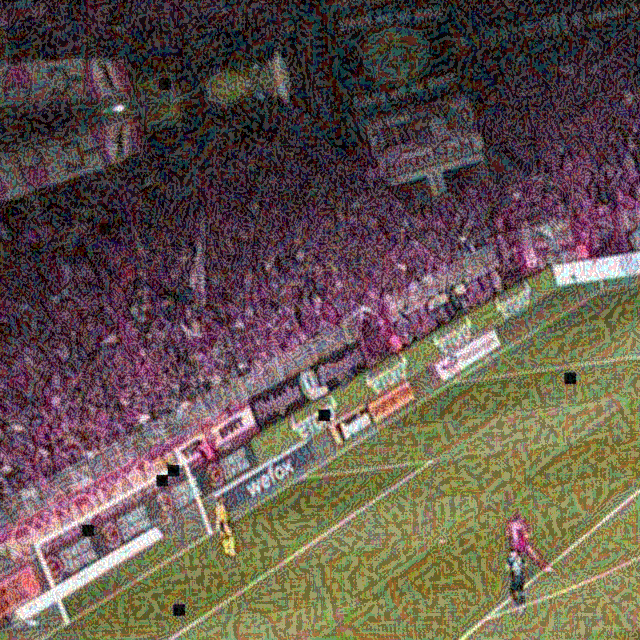

In [ ]:
show_image_tensor_pil(examples[1][59])

In [ ]:
len(examples[0])

61

In [ ]:
# Convert tensor to PIL image
to_pil = ToPILImage()
pil_image = to_pil(examples[0][1].squeeze(0))

pil_image.save('/teamspace/studios/this_studio/test.png')  # Save as PNG or any other format